In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import io
import re
from scipy.io.wavfile import read
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from pathlib import Path
from sklearn.cluster import KMeans
import copy
from scipy.stats import mode


In [187]:
def load_waveform(filepath):
    with open(filepath) as dataFile:
        data = dataFile.read()
        # Check for missing commas and insert them
        pattern = r'(\{[^{}]*"[^"]*"[^{}]*\})(?=[^{}]*\{)'
        data = re.sub(pattern, r'\1,', data)

        obj = data[data.find('{') : data.rfind('}')+1]
        jsonObj = json.loads(obj)
        
        if jsonObj['data']:
            waveform_data = pd.DataFrame(jsonObj['data'], columns=["peak_amplitude","integral","phase_angle","cycle_number","rise_time","pulse_width"])    
            return waveform_data
    return None


In [188]:
def load_dataframes(dirpath):
    dataframes = []
    for filename in os.listdir(dirpath):
        if filename.endswith(".js"):
            filepath = os.path.join(dirpath, filename)
            waveform = load_waveform(filepath)
            if not waveform.empty:
                waveform['filename'] = filename # Add filename as a column
                dataframes.append(waveform)
    return dataframes

In [189]:
# load training data
dirpath1 = "ptest"
dirpath2 = "ntest"
dirpath3 = "utest"
pdf = load_dataframes(dirpath1)
ndf = load_dataframes(dirpath2)
udf = load_dataframes(dirpath3)

In [190]:
dependent_vars = {} # create a dictionary with the assigned dependent variables mapped to the filename as the key
for df, y in zip([pdf, ndf, udf], [1, 2, 0]): # 1 is positive, 2 is negative, 0 is unclassified
    for filename in pd.concat(df)['filename'].unique():
        dependent_vars[filename] = y
# this is used to assign the dependent variables to the filename in the transformed dataframe

In [191]:
# combine all list of dataframes into a single list of dataframes once dependent variables have been assigned
dataframes = pdf + ndf + udf

In [192]:
print(dataframes) # check

[      peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0              -0.24      1219          253          8824          0   
1              -0.24      2616           34          8825          0   
2               0.00     -2638          197          8825          0   
3              -0.24       417          246          8825          0   
4              -0.24      2149           33          8826          0   
...              ...       ...          ...           ...        ...   
5632            0.25       685          315          9322          0   
5633            0.00       563           35          9323          0   
5634            0.25     -1509          353          9323          0   
5635            0.25      -539           22          9324          0   
5636            0.25       684           93          9324          0   

      pulse_width    filename  
0               0  1047582.js  
1               0  1047582.js  
2               0  1047582.js  
3     

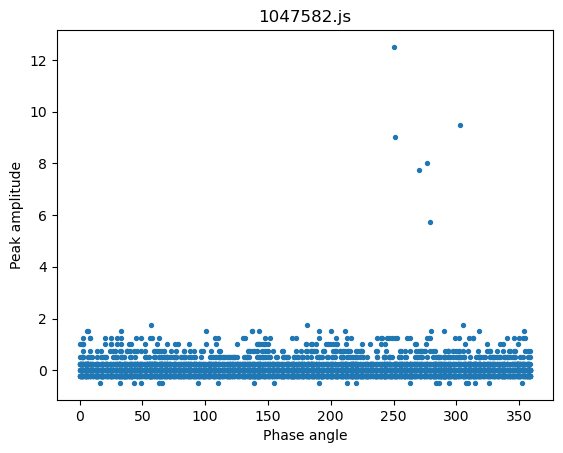

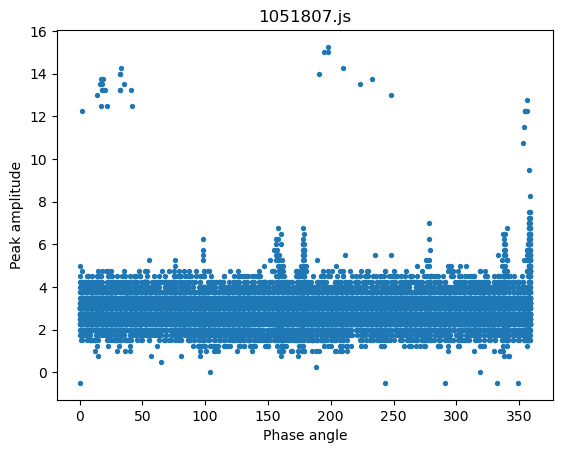

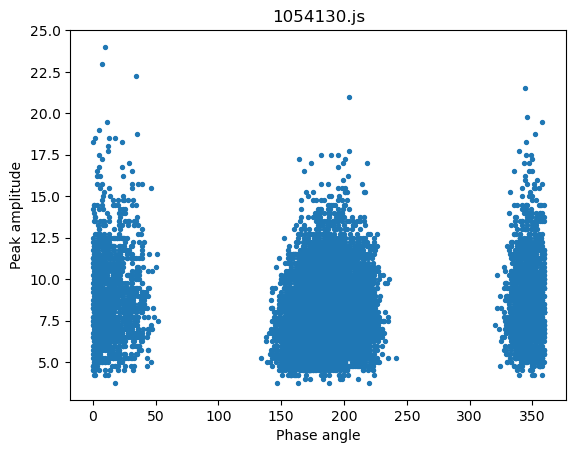

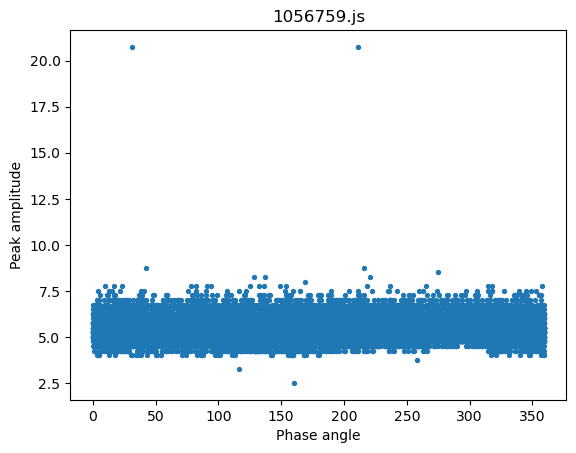

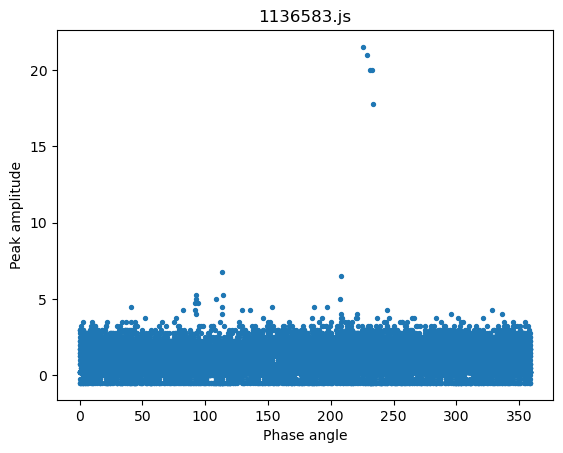

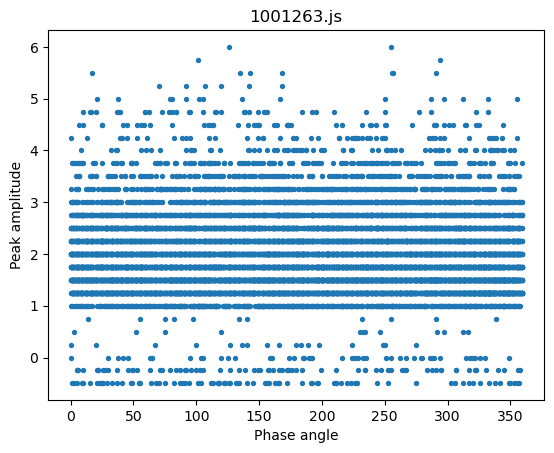

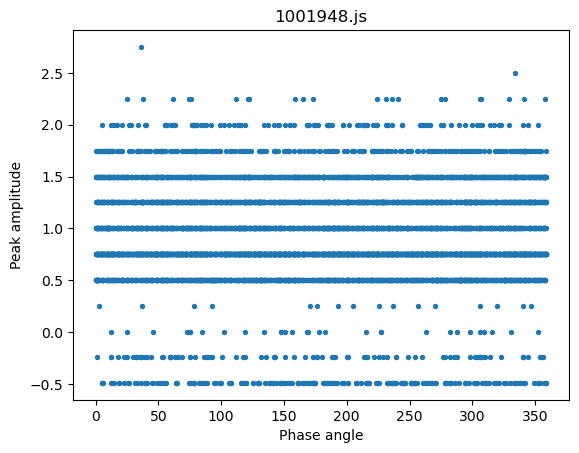

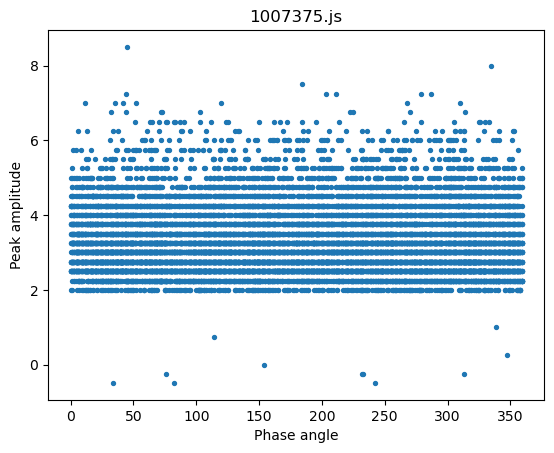

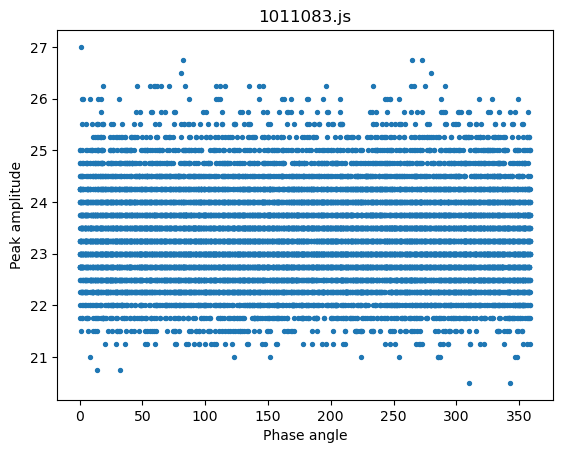

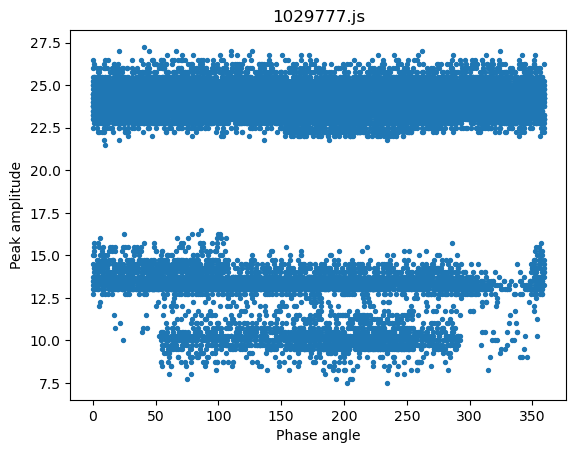

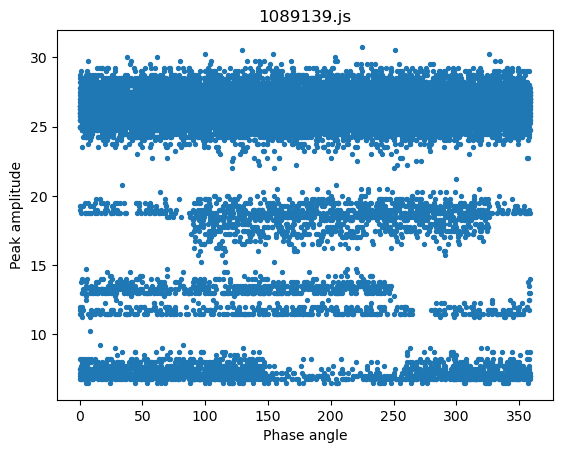

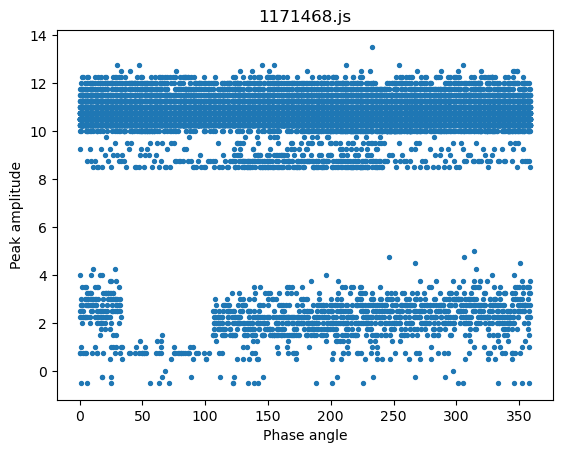

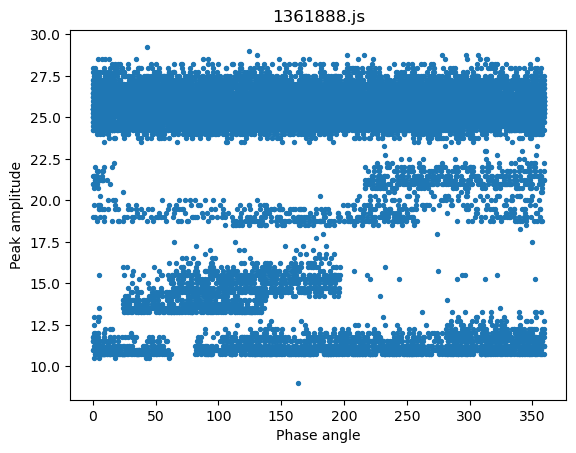

In [193]:
for dataframe in dataframes: # show data into plots
    plt.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    plt.title(dataframe['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()

In [194]:
def determine_baseline(bucket_data, kmeans, predicted_clusters, threshold=5): # algorithm to determine baselines
    centroids = kmeans.cluster_centers_
    centroid_distance = abs(centroids[1] - centroids[0])

    if centroid_distance > threshold:
        # Clusters far apart - Outcome 1
        lower_centroid_index = np.argmin(centroids)
        lower_cluster = bucket_data[predicted_clusters == lower_centroid_index]
        return max(lower_cluster['peak_amplitude'])
    else:
        # Clusters close together - Outcome 2
        higher_centroid_index = np.argmax(centroids)
        return centroids[higher_centroid_index][0]

In [195]:
def denoise_dataframes(dataframes): # function to calculate base-lines and plot the graphs with the new added information
    warnings.filterwarnings('ignore')
    for df in dataframes:
        # if df['peak_amplitude'].max() > 8: # filter out the negative
        #     continue

        # Bucket phase angles
        df['bucket'] = pd.cut(df['phase_angle'], bins=range(0, 361, 10), labels=False)

        # Perform k-means clustering on each bucket and determine baselines
        kmeans_results = []
        bucket_baselines = []
        for i in range(36):
            bucket_data = df[df['bucket'] == i]
            if not bucket_data.empty and len(bucket_data) > 1:
                kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
                kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
                kmeans_results.append((i, kmeans))

                # Predict the clusters for bucket_data
                predicted_clusters = kmeans.predict(bucket_data['peak_amplitude'].values.reshape(-1, 1))

                # Pass the predicted clusters to the determine_baseline function
                baseline = determine_baseline(bucket_data, kmeans, predicted_clusters)
                bucket_baselines.append((i, baseline))
            else:
                kmeans_results.append((i, None))
                bucket_baselines.append((i, None))

        # Assign cluster labels to each data point
        df['cluster'] = np.nan
        for i, kmeans in kmeans_results:
            if kmeans is not None:
                mask = df['bucket'] == i
                df.loc[mask, 'cluster'] = kmeans.predict(df.loc[mask, 'peak_amplitude'].values.reshape(-1, 1))

        baselines = [baseline for _, baseline in bucket_baselines if baseline is not None]
        basemode = mode(baselines).mode[0]

        # Remove points below the baseline mode (inserted)
        df.loc[:, 'filtered'] = df['peak_amplitude'] >= basemode

        # # Scatter plot with bucketed phase angles and clustered data points
        # plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
        # plt.title(df['filename'].iloc[0])
        # plt.xlabel('Phase angle')
        # plt.ylabel('Peak amplitude')

        # # Plot baselines
        # for i, baseline in bucket_baselines:
        #     if baseline is not None:
        #         plt.hlines(baseline, i * 10, (i + 1) * 10 - 1, colors='r', linestyles='dashed')
        # plt.hlines(basemode, 0, 359, colors='b', linestyles='solid')
        # plt.show()

    return dataframes

In [196]:
dataframes = denoise_dataframes(dataframes)

In [197]:
print(dataframes[2]) # check

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                7.25      2040          214          1412          0   
1                6.75     -2831          224          1412          0   
2                7.75      3181          349          1412          0   
3                9.00      2953          349          1412          3   
4               10.00      2895          358          1412          1   
...               ...       ...          ...           ...        ...   
12210            8.00      2215          195          1912          0   
12211            7.50      2639          198          1912          0   
12212            6.25      2464          210          1912          0   
12213            9.25      4814          211          1912          0   
12214            6.75      1789          213          1912          0   

       pulse_width    filename  bucket  cluster  filtered  
0                0  1054130.js    21.0      1.0      True  
1  

In [198]:
filtered_dataframes = [df[df['filtered'] == True] for df in dataframes] # remove all data points below the baseline AKA removing noise
print(filtered_dataframes[1]) # check if remaining values are True, meaning that the data points remaining are the ones that we want to keep

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
88               5.25      5618          359         14019          4   
277              5.75      6301          179         14020          6   
386              5.00      1512          293         14020         81   
396              4.75      2079          297         14020          0   
425             13.25     10931           20         14029         27   
...               ...       ...          ...           ...        ...   
15076            5.00     12290          278         14497        324   
15189            5.75      6239          359         14497         19   
15190            5.00      6267          359         14497         20   
15350            5.25      2227          356         14508          0   
15351            4.75    -11756          359         14508          0   

       pulse_width    filename  bucket  cluster  filtered  
88              49  1051807.js    35.0      1.0      True  
277

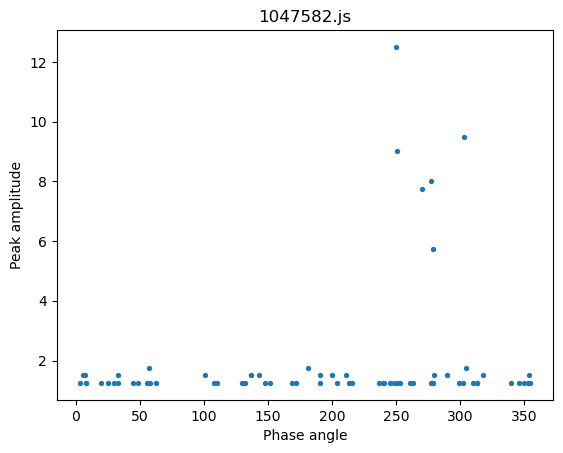

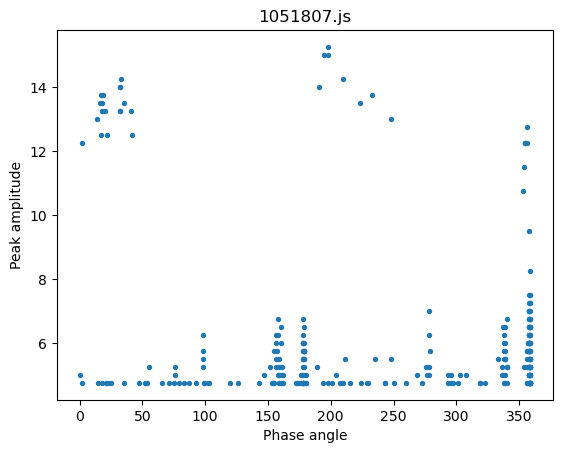

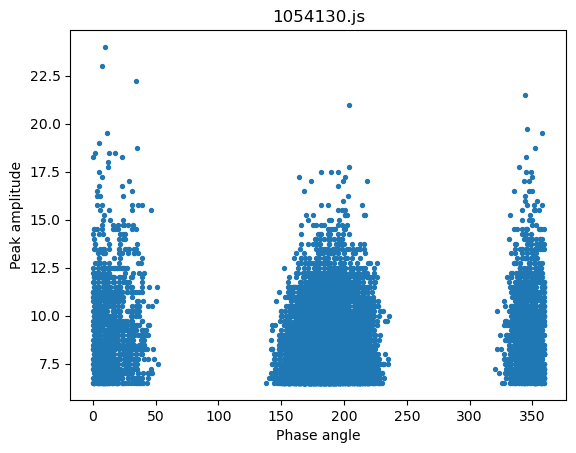

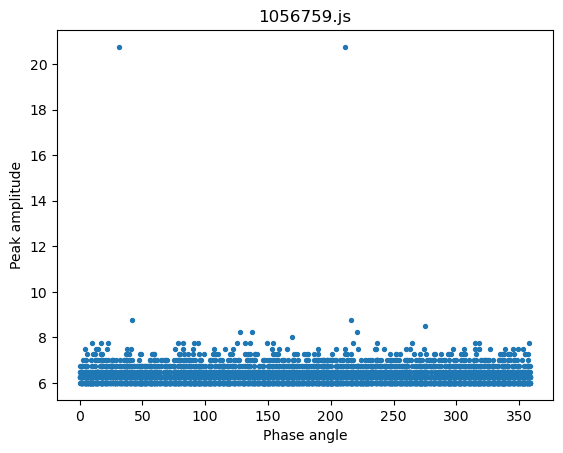

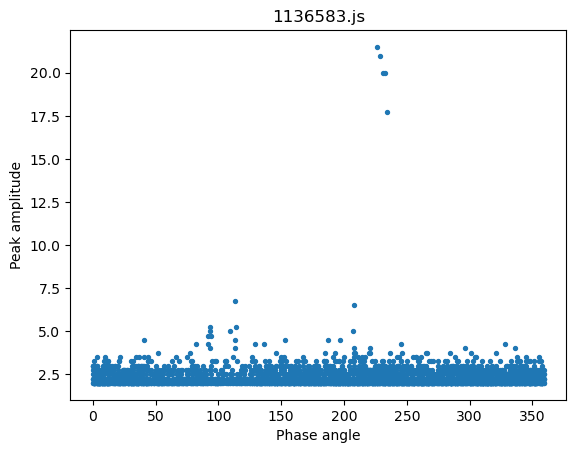

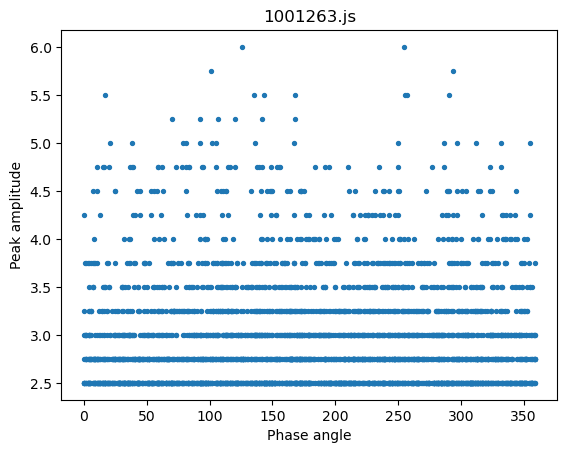

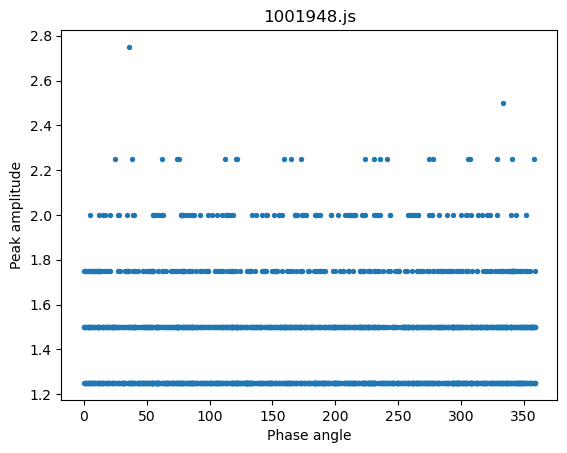

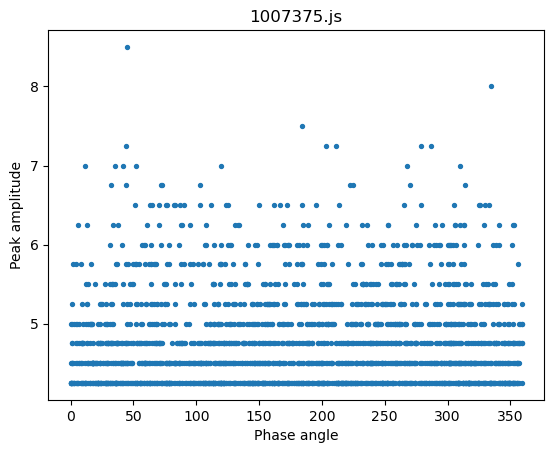

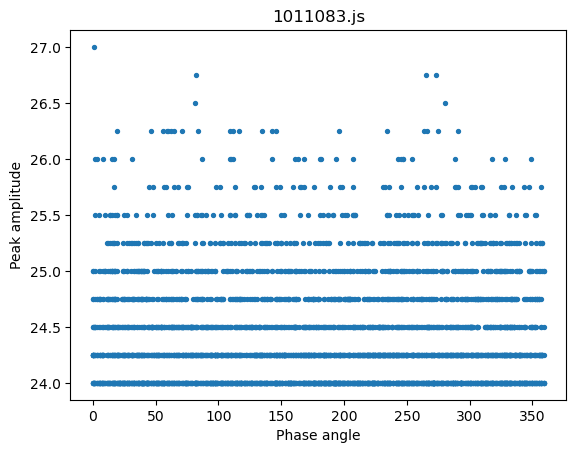

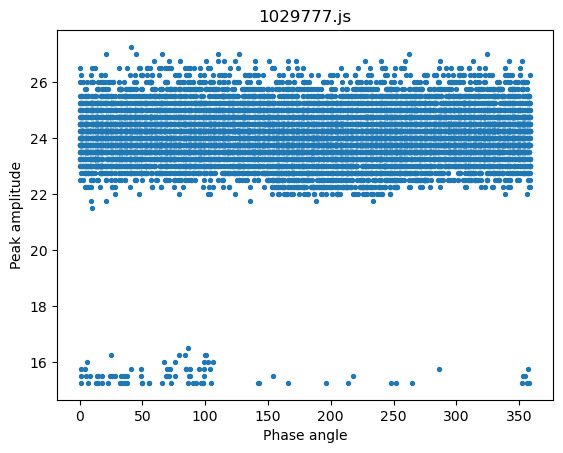

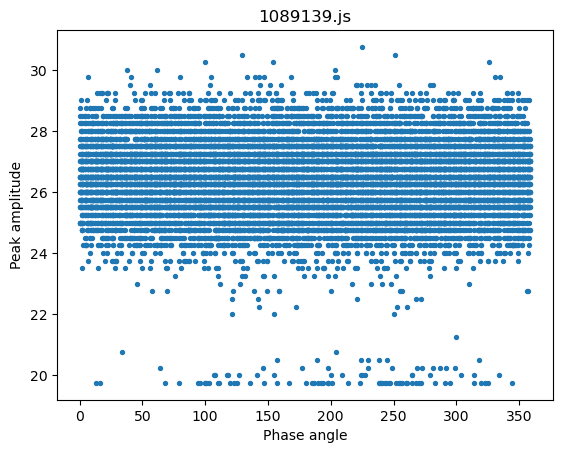

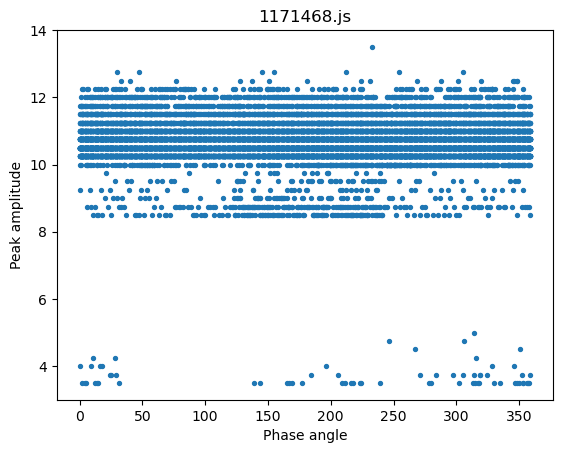

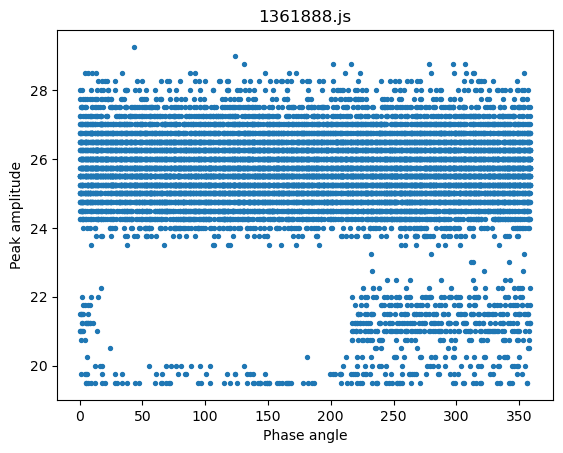

In [199]:
for dataframe in filtered_dataframes: # show new graphs with threshold removed
    fig, ax = plt.subplots()
    ax.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    ax.set_title(dataframe['filename'].iloc[0])
    ax.set_xlabel('Phase angle')
    ax.set_ylabel('Peak amplitude')


In [200]:
# Initialize lists for the cluster features
for df in filtered_dataframes:
    # Extract the relevant columns
    X = df[['phase_angle', 'peak_amplitude']].values
    
    # Apply DBSCAN to the data
    dbscan = DBSCAN(eps=7, min_samples=8)
    dbscan.fit(X)
    labels = dbscan.labels_
    
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['cluster_length'] = np.nan
    df_copy['cluster_height'] = np.nan
    df_copy['cluster_gradient_tr'] = np.nan
    df_copy['cluster_gradient_tl'] = np.nan
    
    # Add the cluster labels to the dataframe copy
    df_copy['cluster'] = labels
    
    # Access cluster information
    clusters = set(labels)
    for cluster in clusters:
        if cluster != -1:
            # Get the points belonging to the cluster
            cluster_points = X[labels == cluster]

            
            # Calculate cluster features
            cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
            cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
            cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
            cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
            # Add new columns for cluster features to the dataframe copy
            df_copy.loc[labels == cluster, 'cluster_length'] = cluster_length
            df_copy.loc[labels == cluster, 'cluster_height'] = cluster_height
            df_copy.loc[labels == cluster, 'cluster_gradient_tr'] = cluster_gradient_tr
            df_copy.loc[labels == cluster, 'cluster_gradient_tl'] = cluster_gradient_tl
    
    # Assign the cluster labels and features to the original dataframe
    df.loc[:, 'cluster'] = df_copy['cluster']
    df.loc[:, 'cluster_length'] = df_copy['cluster_length']
    df.loc[:, 'cluster_height'] = df_copy['cluster_height']
    df.loc[:, 'cluster_gradient_tr'] = df_copy['cluster_gradient_tr']
    df.loc[:, 'cluster_gradient_tl'] = df_copy['cluster_gradient_tl']
    
    # # Plot the clustered data
    # plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    # plt.title(df['filename'].iloc[0])
    # plt.xlabel('Phase angle')
    # plt.ylabel('Peak amplitude')
    # plt.show()


In [201]:
# def plot_cluster_bounds(cluster_points):
#     x_min, x_max = cluster_points[:, 0].min(), cluster_points[:, 0].max()
#     y_min, y_max = cluster_points[:, 1].min(), cluster_points[:, 1].max()
#     plt.plot([x_min, x_max], [y_min, y_min], 'k-', linewidth=2)
#     plt.plot([x_max, x_max], [y_min, y_max], 'k-', linewidth=2)
#     plt.plot([x_max, x_min], [y_max, y_max], 'k-', linewidth=2)
#     plt.plot([x_min, x_min], [y_max, y_min], 'k-', linewidth=2)


# for df in filtered_dataframes:
#     # Extract the relevant columns
#     X = df[['phase_angle', 'peak_amplitude']].values
    
#     # Apply DBSCAN to the data
#     dbscan = DBSCAN(eps=10, min_samples=10)
#     dbscan.fit(X)
#     labels = dbscan.labels_
    
#     # Add the cluster labels to the dataframe
#     df['cluster'] = labels
    
#     # Create new columns for each cluster label
#     dummies = pd.get_dummies(df['cluster'], prefix='cluster')
#     df = pd.concat([df, dummies], axis=1)
    
#     # Access cluster information
#     clusters = set(labels)
#     for cluster in clusters:
#         if cluster != -1:
#             # Get the points belonging to the cluster
#             cluster_points = X[labels == cluster]
            
#             # Calculate cluster features
#             cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
#             cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
#             cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
#             cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
#             # Print cluster information
#             print(f"Cluster {cluster}: Length={cluster_length}, Height={cluster_height}, GradientTR={cluster_gradient_tr}, GradientTL={cluster_gradient_tl}")
            
#             # Plot the boundaries of the cluster
#             plot_cluster_bounds(cluster_points)
    
#     # Plot the clustered data
#     plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
#     plt.title(df['filename'].iloc[0])
#     plt.xlabel('Phase angle')
#     plt.ylabel('Peak amplitude')
#     plt.show()


In [202]:
print(filtered_dataframes[0]) # integers in the cluster column indicate the cluster that they belong to, if its a -1 it means that it is an outlier and is not included in any clusters

      peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
88              1.25       736           45          8862          0   
96              1.25       565          172          8863          0   
109             1.25      3589          130          8864          0   
348             1.25     -1287          108          8887          0   
368             1.25      1715          350          8888          0   
...              ...       ...          ...           ...        ...   
5255            1.50     -2865            6          9289          0   
5376            1.25      1444          241          9298        449   
5413            1.25     -1362          277          9299          0   
5429            1.25       611          245          9301          0   
5430            1.25       354          263          9301          0   

      pulse_width    filename  bucket  cluster  filtered  cluster_length  \
88              0  1047582.js     4.0       -1      True   

In [203]:
# once the relevant graphs have been removed, convert list of dataframes into 1 big dataframe
big_df = pd.concat(filtered_dataframes, ignore_index=True)

In [204]:
big_df.isna().sum() # check number of empty values

peak_amplitude           0
integral                 0
phase_angle              0
cycle_number             0
rise_time                0
pulse_width              0
filename                 0
bucket                 253
cluster                  0
filtered                 0
cluster_length         149
cluster_height         149
cluster_gradient_tr    149
cluster_gradient_tl    149
dtype: int64

In [205]:
big_df.fillna(0, inplace=True) # replace missing values with 0
big_df.isna().sum() # check again


peak_amplitude         0
integral               0
phase_angle            0
cycle_number           0
rise_time              0
pulse_width            0
filename               0
bucket                 0
cluster                0
filtered               0
cluster_length         0
cluster_height         0
cluster_gradient_tr    0
cluster_gradient_tl    0
dtype: int64

In [206]:
# # Calculate additional clustering features based on the cluster labels
# clusters = []
# for filename, file_df in big_df.groupby('filename'):
#     # Assume the cluster labels are stored in the 'cluster' column
#     labels = file_df['cluster'].values
#     unique_labels = np.unique(labels)
#     cluster_count = len(unique_labels)
#     if cluster_count > 0:
#         # Calculate additional clustering features based on the cluster labels
#         # For example, cluster_length, cluster_height, etc.
#         # Append the calculated features to the clusters list
#         cluster_lengths = []
#         cluster_heights = []
#         cluster_gradient_trs = []
#         cluster_gradient_tls = []
#         for label in unique_labels:
#             cluster_points = file_df[file_df['cluster'] == label][['phase_angle', 'peak_amplitude']].values
#             if len(cluster_points) > 1:
#                 cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
#                 cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
#                 cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
#                 cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
#                 cluster_lengths.append(cluster_length)
#                 cluster_heights.append(cluster_height)
#                 cluster_gradient_trs.append(cluster_gradient_tr)
#                 cluster_gradient_tls.append(cluster_gradient_tl)
#         clusters.append({'filename': filename, 'cluster_count': cluster_count, 'cluster_lengths': cluster_lengths, 'cluster_heights': cluster_heights, 'cluster_gradient_trs': cluster_gradient_trs, 'cluster_gradient_tls': cluster_gradient_tls})

# # Convert the clusters list to a dataframe
# clusters_df = pd.DataFrame(clusters)

# final_df = clusters_df

# final_df['anomaly'] = final_df['filename'].apply(lambda x: dependent_vars.get(x, 0)) # call dictionary with filename keys mapped to dependent variables respective to each file

# print(final_df)


In [207]:
# Calculate additional clustering features based on the cluster labels
clusters = []
for filename, file_df in big_df.groupby('filename'):
    # Assume the cluster labels are stored in the 'cluster' column
    labels = file_df['cluster'].values
    unique_labels = np.unique(labels)
    cluster_count = len(unique_labels)
    if cluster_count > 0:
        # Calculate additional clustering features based on the cluster labels
        # For example, cluster_length, cluster_height, etc.
        # Append the calculated features to the clusters list
        cluster_lengths = []
        cluster_heights = []
        cluster_gradient_trs = []
        cluster_gradient_tls = []
        for i in range(4):
            if i < len(unique_labels):
                label = unique_labels[i]
                cluster_points = file_df[file_df['cluster'] == label][['phase_angle', 'peak_amplitude']].values
                if len(cluster_points) > 1:
                    cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
                    cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
                    cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
                    cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
                    cluster_lengths.append(cluster_length)
                    cluster_heights.append(cluster_height)
                    cluster_gradient_trs.append(cluster_gradient_tr)
                    cluster_gradient_tls.append(cluster_gradient_tl)
            else:
                # Fill in zeros for any missing clusters
                cluster_lengths.append(0)
                cluster_heights.append(0)
                cluster_gradient_trs.append(0)
                cluster_gradient_tls.append(0)
        clusters.append({'filename': filename, 'cluster_count': cluster_count, 'cluster_lengths': cluster_lengths, 'cluster_heights': cluster_heights, 'cluster_gradient_trs': cluster_gradient_trs, 'cluster_gradient_tls': cluster_gradient_tls})

# Convert the clusters list to a dataframe
clusters_df = pd.DataFrame(clusters)

final_df = clusters_df

final_df['anomaly'] = final_df['filename'].apply(lambda x: dependent_vars.get(x, 0)) # call dictionary with filename keys mapped to dependent variables respective to each file

print(final_df)


      filename  cluster_count         cluster_lengths         cluster_heights  \
0   1001263.js              1        [359.0, 0, 0, 0]          [3.5, 0, 0, 0]   
1   1001948.js              1        [359.0, 0, 0, 0]          [1.5, 0, 0, 0]   
2   1007375.js              1        [359.0, 0, 0, 0]         [4.25, 0, 0, 0]   
3   1011083.js              1        [359.0, 0, 0, 0]          [3.0, 0, 0, 0]   
4   1029777.js              2    [123.0, 359.0, 0, 0]       [0.0, 12.0, 0, 0]   
5   1047582.js              1        [352.0, 0, 0, 0]        [11.25, 0, 0, 0]   
6   1051807.js              8  [323.0, 6.0, 8.0, 8.0]  [10.5, 8.0, 2.0, 1.25]   
7   1054130.js              3   [98.0, 39.0, 52.0, 0]   [14.5, 15.0, 17.5, 0]   
8   1056759.js              2    [180.0, 359.0, 0, 0]       [0.0, 2.75, 0, 0]   
9   1089139.js              1        [359.0, 0, 0, 0]         [11.0, 0, 0, 0]   
10  1136583.js              2      [8.0, 359.0, 0, 0]      [3.75, 4.75, 0, 0]   
11  1171468.js              

In [208]:
final_df.to_csv('test1.csv', index=False)

In [209]:
df = final_df
# Expand the list columns into separate columns
expanded_df = pd.concat([df.drop(['cluster_lengths', 'cluster_heights', 'cluster_gradient_trs', 'cluster_gradient_tls'], axis=1),
                         df['cluster_lengths'].apply(pd.Series).add_prefix('cluster_length_'),
                         df['cluster_heights'].apply(pd.Series).add_prefix('cluster_height_'),
                         df['cluster_gradient_trs'].apply(pd.Series).add_prefix('cluster_gradient_tr_'),
                         df['cluster_gradient_tls'].apply(pd.Series).add_prefix('cluster_gradient_tl_')],
                        axis=1)

# Fill NaN values with 0
expanded_df.fillna(0, inplace=True)

# be sure to include this in your model training code so that the filename and anomalies are not calculated as features!
# Define the features and target variables:
# features = expanded_df.columns.tolist()
# features.remove('filename')
# features.remove('anomaly')
# target = 'anomaly'

In [210]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
# Split the data into training and testing sets
train_dfs, test_dfs = train_test_split(expanded_df, test_size=0.2, random_state=42)

# Define the features and target variables
features = expanded_df.columns.tolist()
features.remove('filename')
features.remove('anomaly')
target = 'anomaly'

# Train the decision tree model
DecisionTreeClassifierModel = DecisionTreeClassifier(random_state=42)
DecisionTreeClassifierModel.fit(train_dfs[features], train_dfs[target])

# Make predictions on the testing set
predictions = DecisionTreeClassifierModel.predict(test_dfs[features])

# Calculate the accuracy of the model
accuracy = accuracy_score(test_dfs[target], predictions)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(test_dfs[target], predictions)
print(report)


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [211]:
print(expanded_df)
expanded_df.to_csv('test1.1.csv', index=False)

      filename  cluster_count  anomaly  cluster_length_0  cluster_length_1  \
0   1001263.js              1        2             359.0               0.0   
1   1001948.js              1        2             359.0               0.0   
2   1007375.js              1        2             359.0               0.0   
3   1011083.js              1        2             359.0               0.0   
4   1029777.js              2        0             123.0             359.0   
5   1047582.js              1        1             352.0               0.0   
6   1051807.js              8        1             323.0               6.0   
7   1054130.js              3        1              98.0              39.0   
8   1056759.js              2        1             180.0             359.0   
9   1089139.js              1        0             359.0               0.0   
10  1136583.js              2        1               8.0             359.0   
11  1171468.js              1        0             359.0        

In [215]:
def preprocess_data(dataframes):
    dataframes = denoise_dataframes(dataframes) # de-noise the list of dataframes
    filtered_dataframes = [df[df['filtered'] == True] for df in dataframes] # remove all data points below the baseline AKA removing noise
    # Initialize lists for the cluster features
    for df in filtered_dataframes:
        # Extract the relevant columns
        X = df[['phase_angle', 'peak_amplitude']].values
        
        # Apply DBSCAN to the data
        dbscan = DBSCAN(eps=7, min_samples=8)
        dbscan.fit(X)
        labels = dbscan.labels_
        
        # Create a copy of the dataframe to avoid SettingWithCopyWarning
        df_copy = df.copy()
        df_copy['cluster_length'] = np.nan
        df_copy['cluster_height'] = np.nan
        df_copy['cluster_gradient_tr'] = np.nan
        df_copy['cluster_gradient_tl'] = np.nan
        
        # Add the cluster labels to the dataframe copy
        df_copy['cluster'] = labels
        
        # Access cluster information
        clusters = set(labels)
        for cluster in clusters:
            if cluster != -1:
                # Get the points belonging to the cluster
                cluster_points = X[labels == cluster]

                
                # Calculate cluster features
                cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
                cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
                cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
                cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
                
                # Add new columns for cluster features to the dataframe copy
                df_copy.loc[labels == cluster, 'cluster_length'] = cluster_length
                df_copy.loc[labels == cluster, 'cluster_height'] = cluster_height
                df_copy.loc[labels == cluster, 'cluster_gradient_tr'] = cluster_gradient_tr
                df_copy.loc[labels == cluster, 'cluster_gradient_tl'] = cluster_gradient_tl
        
        # Assign the cluster labels and features to the original dataframe
        df.loc[:, 'cluster'] = df_copy['cluster']
        df.loc[:, 'cluster_length'] = df_copy['cluster_length']
        df.loc[:, 'cluster_height'] = df_copy['cluster_height']
        df.loc[:, 'cluster_gradient_tr'] = df_copy['cluster_gradient_tr']
        df.loc[:, 'cluster_gradient_tl'] = df_copy['cluster_gradient_tl']
        
        # # Plot the clustered data
        # plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
        # plt.title(df['filename'].iloc[0])
        # plt.xlabel('Phase angle')
        # plt.ylabel('Peak amplitude')
        # plt.show()

    # once the relevant graphs have been removed, convert list of dataframes into 1 big dataframe
    big_df = pd.concat(filtered_dataframes, ignore_index=True)
    big_df.fillna(0, inplace=True) # replace missing values with 0
    # Calculate additional clustering features based on the cluster labels
    # Calculate additional clustering features based on the cluster labels
    clusters = []
    for filename, file_df in big_df.groupby('filename'):
        # Assume the cluster labels are stored in the 'cluster' column
        labels = file_df['cluster'].values
        unique_labels = np.unique(labels)
        cluster_count = len(unique_labels)
        if cluster_count > 0:
            # Calculate additional clustering features based on the cluster labels
            # For example, cluster_length, cluster_height, etc.
            # Append the calculated features to the clusters list
            cluster_lengths = []
            cluster_heights = []
            cluster_gradient_trs = []
            cluster_gradient_tls = []
            for i in range(4):
                if i < len(unique_labels):
                    label = unique_labels[i]
                    cluster_points = file_df[file_df['cluster'] == label][['phase_angle', 'peak_amplitude']].values
                    if len(cluster_points) > 1:
                        cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
                        cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
                        cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
                        cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
                        cluster_lengths.append(cluster_length)
                        cluster_heights.append(cluster_height)
                        cluster_gradient_trs.append(cluster_gradient_tr)
                        cluster_gradient_tls.append(cluster_gradient_tl)
                else:
                    # Fill in zeros for any missing clusters
                    cluster_lengths.append(0)
                    cluster_heights.append(0)
                    cluster_gradient_trs.append(0)
                    cluster_gradient_tls.append(0)
            clusters.append({'filename': filename, 'cluster_count': cluster_count, 'cluster_lengths': cluster_lengths, 'cluster_heights': cluster_heights, 'cluster_gradient_trs': cluster_gradient_trs, 'cluster_gradient_tls': cluster_gradient_tls})

    # Convert the clusters list to a dataframe
    clusters_df = pd.DataFrame(clusters)

    final_df = clusters_df

    print(final_df)

    df = final_df
    # Expand the list columns into separate columns
    expanded_df = pd.concat([df.drop(['cluster_lengths', 'cluster_heights', 'cluster_gradient_trs', 'cluster_gradient_tls'], axis=1),
                            df['cluster_lengths'].apply(pd.Series).add_prefix('cluster_length_'),
                            df['cluster_heights'].apply(pd.Series).add_prefix('cluster_height_'),
                            df['cluster_gradient_trs'].apply(pd.Series).add_prefix('cluster_gradient_tr_'),
                            df['cluster_gradient_tls'].apply(pd.Series).add_prefix('cluster_gradient_tl_')],
                            axis=1)

    # Fill NaN values with 0
    expanded_df.fillna(0, inplace=True)
    print(expanded_df)
    return expanded_df

def getFeatures(final_df):
    features = final_df.columns.tolist()
    features.remove('filename')
    # features.remove('cluster_count')
    return features

In [221]:
# to apply the trained model onto any new test dataset, the new test dataset must have the same number of features
# meaning that we must apply the HDBScan clustering to the new test data, generate its columns, before finally 
# loading it into the model using predictions = model.predict(new_data[features])

# step 1: load folder containing all testing files into a list of dataframes
dirpath = "test" # name of folder
to_be_predicted_df = load_dataframes(dirpath)

# step 2: preprocess the data, which entails removing noise, getting cluster information for comparison, and dataframe conversion to include only the relevant features
to_be_predicted_df = preprocess_data(to_be_predicted_df)



      filename  cluster_count         cluster_lengths         cluster_heights  \
0   1017547.js              1        [359.0, 0, 0, 0]         [2.25, 0, 0, 0]   
1   1018183.js              1        [359.0, 0, 0, 0]          [3.5, 0, 0, 0]   
2   1020314.js              1        [359.0, 0, 0, 0]         [2.25, 0, 0, 0]   
3   1025150.js              1        [359.0, 0, 0, 0]          [4.0, 0, 0, 0]   
4   1026615.js              1        [351.0, 0, 0, 0]         [0.75, 0, 0, 0]   
5   1027092.js              1        [359.0, 0, 0, 0]          [3.5, 0, 0, 0]   
6   1029777.js              2    [123.0, 359.0, 0, 0]       [0.0, 12.0, 0, 0]   
7   1032494.js              1        [359.0, 0, 0, 0]         [2.75, 0, 0, 0]   
8   1034768.js              1        [359.0, 0, 0, 0]          [2.0, 0, 0, 0]   
9   1040048.js              1        [359.0, 0, 0, 0]          [4.0, 0, 0, 0]   
10  1047582.js              1        [352.0, 0, 0, 0]        [11.25, 0, 0, 0]   
11  1051807.js              

In [222]:
f = getFeatures(to_be_predicted_df)
X = to_be_predicted_df[f]
predictions = DecisionTreeClassifierModel.predict(X)
# print(getFeatures(to_be_predicted_df).dtypes)
print(predictions)


[2 2 2 2 1 2 0 2 2 2 1 1 1 1 0]


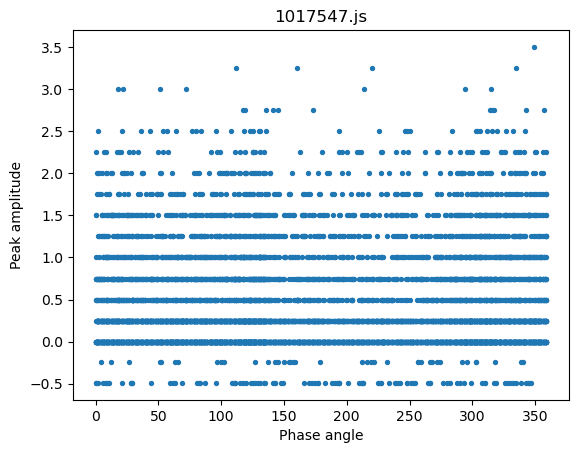

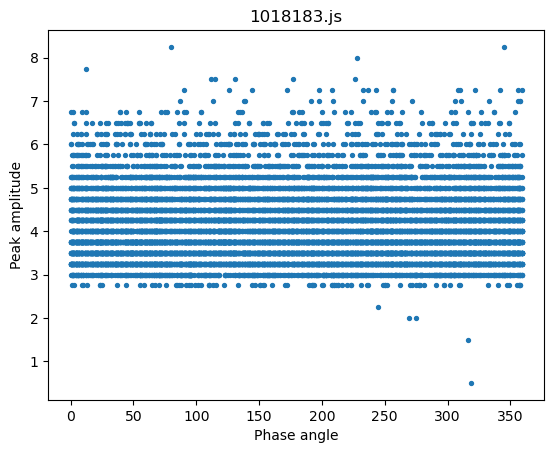

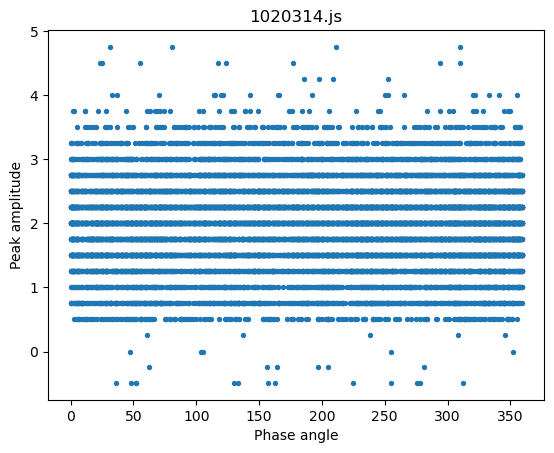

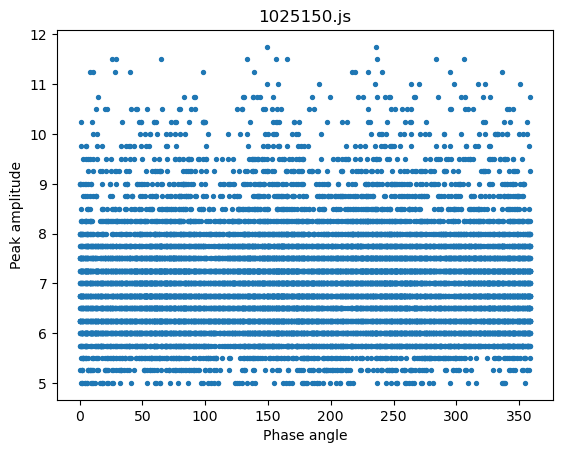

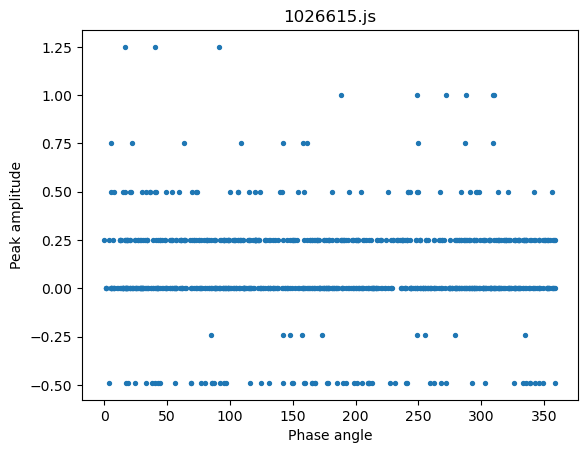

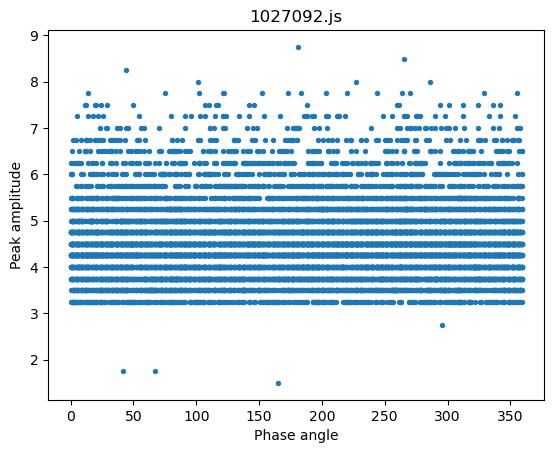

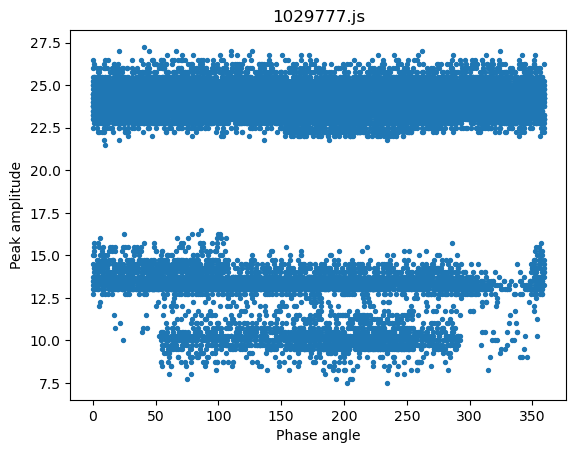

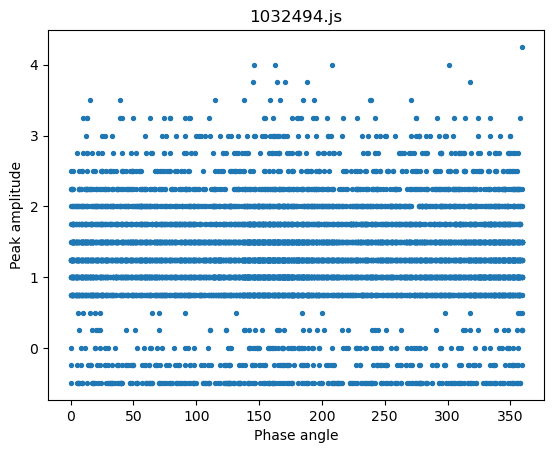

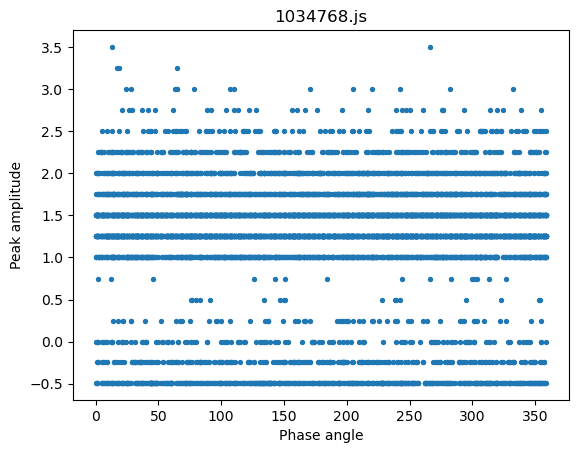

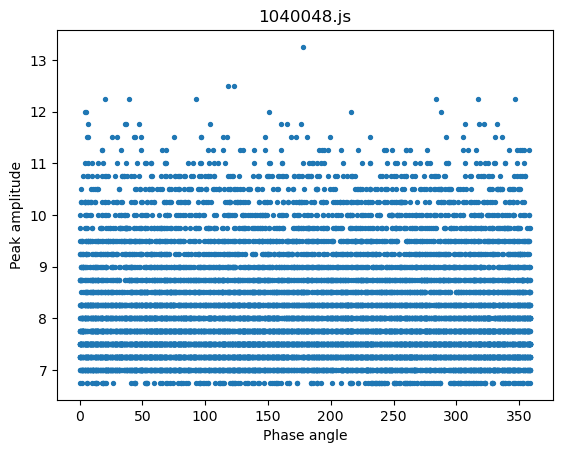

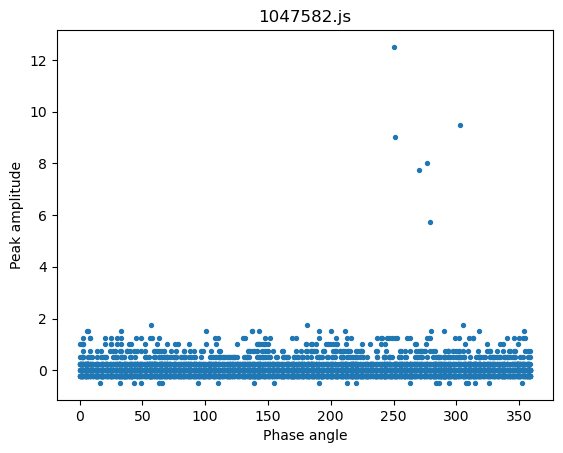

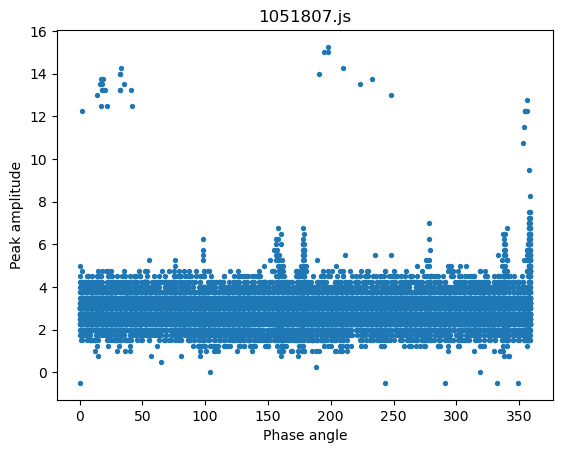

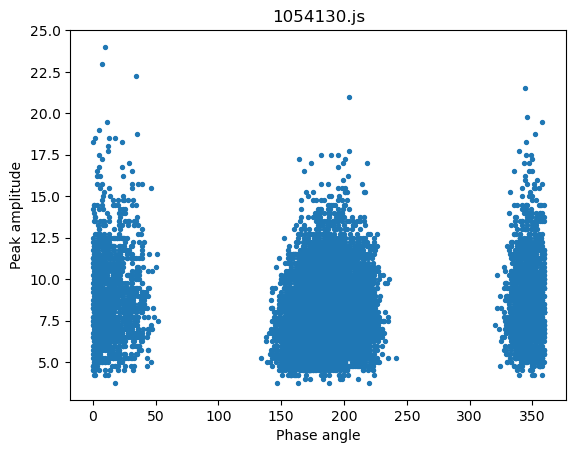

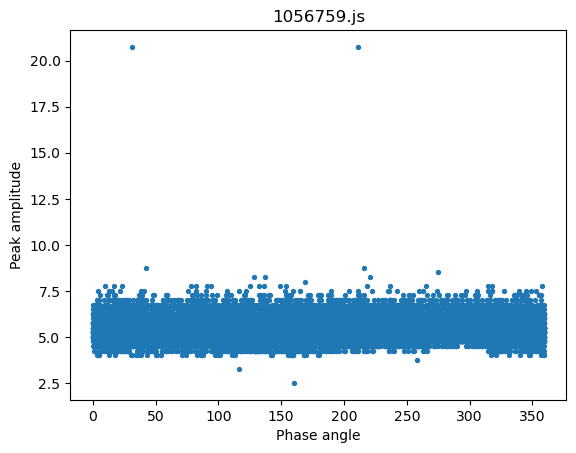

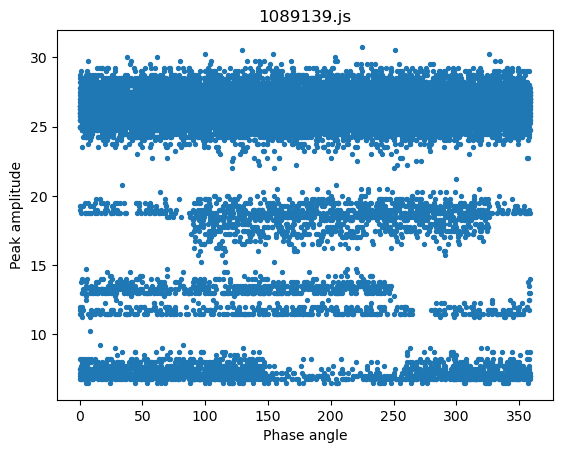

In [223]:
placeholder_df = load_dataframes(dirpath)
for dataframe in placeholder_df: # show data into plots
    plt.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    plt.title(dataframe['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()